In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy . optimize import minimize
from scipy import linalg
import math
from copy import copy
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(0)
N = 100
half_n = N//2
r = 10
s1 = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s1*np.random.randn(half_n)
x1, y1 = (r+n)*np.cos(t), (r+n)*np.sin(t)

x_cir_cor,y_cir_cor = r*np.cos(t), r*np.sin(t)

X_circ = np.hstack((x1.reshape(half_n, 1), y1.reshape(half_n, 1 )))

m, b = -1, 2
x2 = np.linspace(-12, 12, half_n)
y2 = m*x2 + b + s1*np.random.randn(half_n)
X_line = np.hstack((x2.reshape(half_n, 1), y2.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

x_con = np.concatenate([x1,x2])
y_con = np.concatenate([y1,y2])


In [3]:
e = 0.4
sam = 3
d = 50
p=0.99
num_s = np.log(1-p)/np.log(1-(1-e)**sam)

Estimation Manually

In [111]:
in_count = 0

while in_count<55:
    a1 = np.random.randint(0,100)
    a2 = np.random.randint(0,100)
    a3 = np.random.randint(0,100)

    x_cor1, y_cor1 = x_con[a1],y_con[a1]
    x_cor2, y_cor2 = x_con[a2],y_con[a2]
    x_cor3, y_cor3 = x_con[a3],y_con[a3]

    x_points = (x_cor1, x_cor2, x_cor3)
    y_points = (y_cor1, y_cor2, y_cor3)

    c = (x_cor1-x_cor2)**2 + (y_cor1-y_cor2)**2
    a = (x_cor2-x_cor3)**2 + (y_cor2-y_cor3)**2
    b = (x_cor3-x_cor1)**2 + (y_cor3-y_cor1)**2

    s = 2*(a*b + b*c + c*a) - (a*a + b*b + c*c)

    cen_x = (a*(b+c-a)*x_cor1 + b*(c+a-b)*x_cor2 + c*(a+b-c)*x_cor3) / s
    cen_y = (a*(b+c-a)*y_cor1 + b*(c+a-b)*y_cor2 + c*(a+b-c)*y_cor3) / s 

    ar = a**0.5
    br = b**0.5
    cr = c**0.5 

    r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5

    center = (cen_x, cen_y)

    up_t = r+s1*1.65
    low_t = r-s1*1.65
    
    in_count = 0
    in_list_x = []
    in_list_y = []
    for i in range(len(x_con)):
        if math.dist((x_con[i],y_con[i]),(cen_x,cen_y))>=low_t and math.dist((x_con[i],y_con[i]),(cen_x,cen_y))<=up_t:
            in_count+=1
            in_list_x.append(x_con[i])
            in_list_y.append(y_con[i])
            
    if in_count >=53 and r<20:
        # fig, ax2 = plt.subplots(1,1,figsize=(10,10))
        # circle2 = plt.Circle((cen_x, cen_y), r, color='b',fill=False)

        # ax2.axis('equal')
        # ax2.scatter(x1, y1, color='k')
        # ax2.scatter(x2, y2, color='k')
        # ax2.scatter(in_list_x, in_list_y, color='y')
        # ax2.scatter(x_points, y_points,color='r')
        # ax2.scatter(cen_x,cen_y,color='b',marker='+')
        # ax2.add_patch(circle2)

        print(in_count)
        break



53


In [36]:
in_list_x

[-8.516684674533817,
 -7.732490839955598,
 -9.342001030021294,
 -8.17674937397819,
 -6.38025319796503,
 -8.308775035851893,
 7.67227518758244,
 9.195351739277744,
 -7.615807763217815,
 2.50899098645394,
 -9.109878761278049,
 -9.083870693393505,
 9.16600473435582,
 9.05786244234232,
 8.699965363697183,
 9.526161193500183,
 4.848650883323003,
 1.685959099667122,
 6.692183032758017,
 9.406255829288003,
 2.7118685758077445,
 -9.81618802610293,
 1.85858914279439,
 6.613230298374064,
 -6.562541079009443,
 5.858321938682398,
 9.432264293618218,
 -10.357317613801575,
 -8.665889155948063,
 -0.9783188158533562,
 1.399711546198396,
 -9.86483022755637,
 -8.700681530391371,
 9.389930604827876,
 -7.123201436251488,
 -7.472144801039948,
 -7.4462458629496355,
 8.698666186162182,
 -4.387907834717077,
 -6.535206569626395,
 -8.341520687402756,
 -5.362522419706444,
 -4.728597784192157,
 2.298740061265848,
 -3.895467415361226,
 -7.052741807914162,
 -6.122448979591837,
 -5.63265306122449,
 7.102040816326529

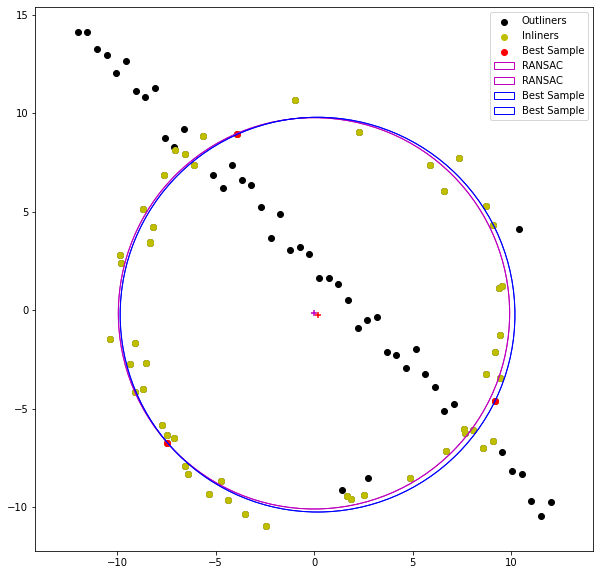

In [129]:
# Coordinates of the 2D points
x = in_list_x
y = in_list_y

# coordinates of the barycenter
x_m = np.mean(x)
y_m = np.mean(y)

# calculation of the reduced coordinates
u = x - x_m
v = y - y_m

# linear system defining the center in reduced coordinates (uc, vc):
#    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
#    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
Suv  = sum(u*v)
Suu  = sum(u**2)
Svv  = sum(v**2)
Suuv = sum(u**2 * v)
Suvv = sum(u*v**2)
Suuu = sum(u**3)
Svvv = sum(v**3)

# Solving the linear system
A = np.array([[Suu, Suv], [Suv, Svv]])
B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
uc, vc = linalg.solve(A, B)

xc_1 = x_m + uc
yc_1 = y_m + vc

# Calculation of all distances from the center (xc_1, yc_1)
Ri_1      = np.sqrt((x-xc_1)**2 + (y-yc_1)**2)
R_1       = np.mean(Ri_1)
residu_1  = sum((Ri_1-R_1)**2)
residu2_1 = sum((Ri_1**2-R_1**2)**2)

cen = (xc_1,yc_1)

fig, ax2 = plt.subplots(1,1,figsize=(10,10))
ax2.axis('equal')

ax2.scatter(xc_1,yc_1,color='m',marker='+')
ax2.scatter(cen_x,cen_y,color='r',marker='+')

ax2.scatter(x1, y1, color='k', label='Outliners')
ax2.scatter(x2, y2, color='k')
ax2.scatter(x, y,color='y', label='Inliners')
ax2.scatter(x_points, y_points, color='r', label='Best Sample')


circle = plt.Circle((xc_1, yc_1), R_1, color='m',fill=False, label='RANSAC')
ax2.add_artist(circle)
ax2.add_patch(circle)

circle2 = plt.Circle((cen_x, cen_y), r, color='b',fill=False, label='Best Sample')
ax2.add_artist(circle2)
ax2.add_patch(circle2)


ax2.legend()

In [24]:
in_count

7